# Resources and credit:
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html
- Conceptual: https://medium.com/@hirotoschwert/digging-into-detectron-2-part-5-6e220d762f9
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

# Registration
*Register train, test, test_offshore, test_inshore datasets*

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [3]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from detectron2.structures import BoxMode
# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])

In [5]:
# Instances of metadata
train_metadata = MetadataCatalog.get('train')
test_metadata = MetadataCatalog.get('test')
test_offshore = MetadataCatalog.get('test_offshore')
train_offshore = MetadataCatalog.get('train_offshore')

# Model Loading

In [8]:
# Quick copy/paste of models
# "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_23_2021_36000iters"
#"COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [9]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_23_2021_36000iters" # Replace w/ folder

/content/drive/MyDrive/SSDD


In [10]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # Replace w/ config
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship)
cfg.OUTPUT_DIR = model_name
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # pg.23 of Zhang et al.
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.5 # pg.23 of Zhang et al.

## Initialize Trainer
*Hidden for brevity*

In [11]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[02/11 05:54:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Evaluation

## Background

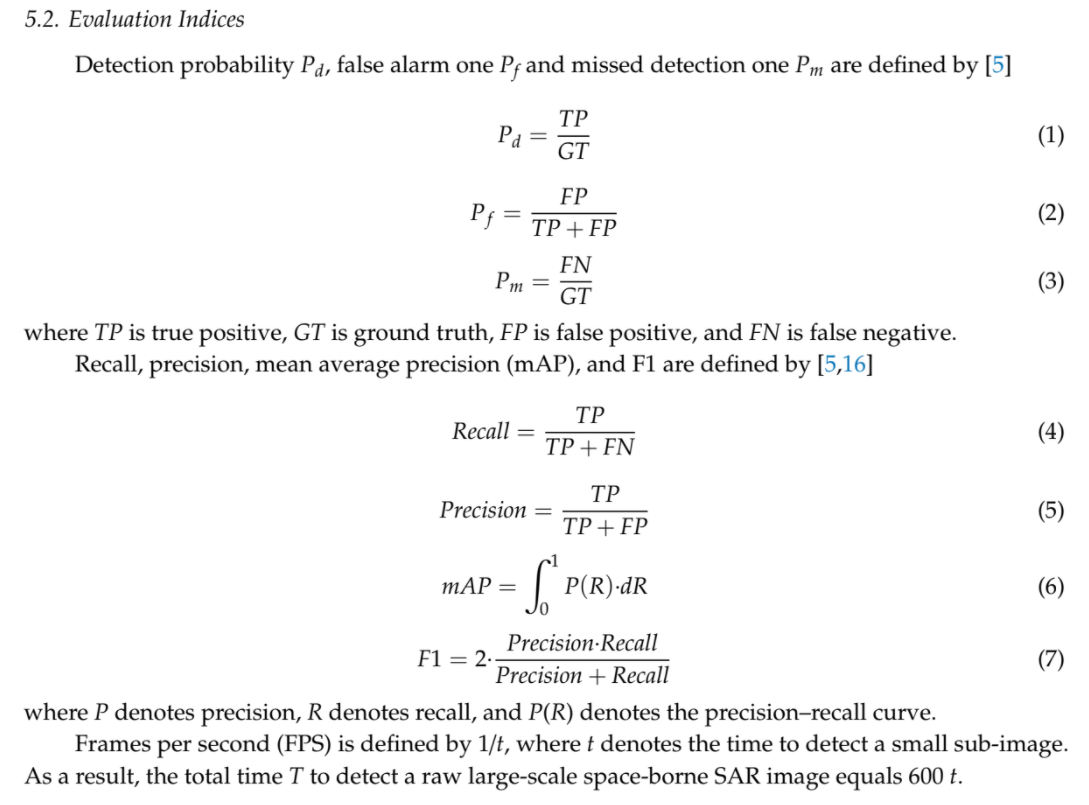

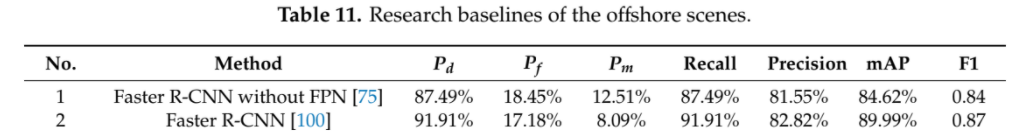

## Prediction

### Custom Evaluator

Follows: https://cs230.stanford.edu/section/7/

In [14]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [15]:
def average_precision(correct, ground_truth): 
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)

  # Interpolate precision (replace each precision value with the maximum
  # precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
test = [True, True, False, False, False, True, True, False, False, True]
recall, precision, AP = average_precision(test, 5)
assert AP == 0.5285714285714286
assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
assert precision == [1.0, 
                    1.0, 
                    0.6666666666666666,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5,
                    0.5,
                    0.5]

In [51]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
    ):
      """
      Args:
          dataset_name (str): name of the dataset to be evaluated.
              It must have either the following corresponding metadata:

                  "json_file": the path to the COCO format annotation

              Or it must be in detectron2's standard dataset format
              so it can be converted to COCO format automatically.
          output_dir (str): an output directory to dump all
              results predicted on the dataset. The dump contains two files:

              1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                  a file that can be loaded with `torch.load` and
                  contains all the results in the format they are produced by the model.
              2. "coco_instances_results.json" a json file in COCO's result format.
      """
      self._cpu_device = torch.device("cpu")
      self.dataset_name = dataset_name
      self._metadata = MetadataCatalog.get(dataset_name)
      self._output_dir = output_dir
      if not hasattr(self._metadata, "json_file"):
        cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
        self._metadata.json_file = cache_path
        convert_to_coco_json(dataset_name, cache_path)

      json_file = PathManager.get_local_path(self._metadata.json_file)
      with contextlib.redirect_stdout(io.StringIO()):
          self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir,
                                     self.dataset_name + "_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    """
    iou_threshold = 0.5 # pg.23 of Zhang et al. 
    num_instances = 0
    num_pos = 0 # must be equal to GT
    gt_overlaps = []
    scores = []
    correct = []
    bad_images = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop overall all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

      num_pos += len(gt_boxes)

      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores best pred/gt iou
      _scores = torch.zeros(len(in_scores)) # stores iou for each score
      
      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)

          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]
          assert _gt_overlaps[j] == gt_ovr

          # record this iou coverage for score
          _scores[box_ind] =  overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1

      # update collectors
      _correct = (_scores >= iou_threshold).tolist()

      if _correct and sum(np.invert(_correct)) > 0:
        bad_images.append(prediction_dict)
      assert len(_correct) == len(_scores) == len(predictions)
      scores.append(in_scores)
      correct.append(_correct)
      gt_overlaps.append(_gt_overlaps)

    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)

    # stores TP/FP for each proposal box in all images 
    # (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2*(precision * recall) / (precision + recall)
    recalls, precisions, mAP = average_precision(correct, GT)

    plot =  {"recalls": recalls, "precisions": precisions}
    hist = {"gt_overlap" : gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }
    return copy.deepcopy(self._results), plot, hist, bad_images

### Training Predictions

In [71]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('train', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
custEval = CustomEvaluator('train', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'train')

[02/11 06:44:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/11 06:44:02 d2.data.common]: Serializing 6000 elements to byte tensors and concatenating them all ...
[02/11 06:44:02 d2.data.common]: Serialized dataset takes 1.01 MiB


In [ ]:
inference = inference_on_dataset(trainer.model,
                                 val_loader,
                                 custEval)

In [72]:
# Alternatively, load predictions directly from file into custEval instance
#temp = custEval._predictions
temp = torch.load(os.path.join(cfg.OUTPUT_DIR, "train_predictions.pth"))
custEval._predictions = temp
# evaluator._predictions = temp
# evaluator.evaluate()

In [74]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.6187134502923975,
 'FN': 1521,
 'FP': 1087,
 'GT': 3637,
 'Pd': 0.5817981853175694,
 'Pf': 0.33936934124258505,
 'Pm': 0.41820181468243056,
 'TP': 2116,
 'mAP': 0.5232960410635557,
 'precision': 0.6606306587574149,
 'recall': 0.5817981853175694}

In [ ]:
# Precision Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.show()

In [ ]:
# Scores of when gt_overlaps when (len(gt_box) != 0)
plt.hist(hist['scores'])
plt.show()

In [ ]:
# iou values for all matching instances (no threshold)
plt.hist(hist['gt_overlap'])
plt.show()

### Test Predictions

In [52]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
custEval = CustomEvaluator('test', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'test')

[02/11 06:09:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/11 06:09:17 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[02/11 06:09:17 d2.data.common]: Serialized dataset takes 0.53 MiB


In [ ]:
inference = inference_on_dataset(trainer.model,
                                 val_loader,
                                 custEval)

In [53]:
# Alternatively, load predictions directly from file into custEval instance
#temp = custEval._predictions
temp = torch.load(os.path.join(cfg.OUTPUT_DIR, "test_predictions.pth"))
custEval._predictions = temp
# evaluator._predictions = temp
# evaluator.evaluate()

In [54]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.7437774524158126,
 'FN': 600,
 'FP': 625,
 'GT': 2378,
 'Pd': 0.7476871320437343,
 'Pf': 0.2600915522263837,
 'Pm': 0.2523128679562658,
 'TP': 1778,
 'mAP': 0.7132523839390086,
 'precision': 0.7399084477736163,
 'recall': 0.7476871320437343}

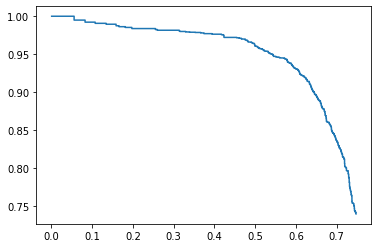

In [20]:
# Precision Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.show()

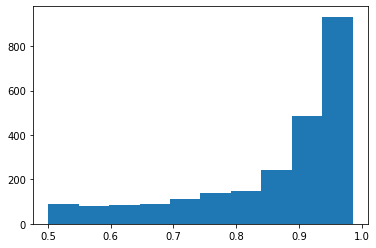

In [21]:
# Scores of when gt_overlaps when (len(gt_box) != 0)
plt.hist(hist['scores'])
plt.show()

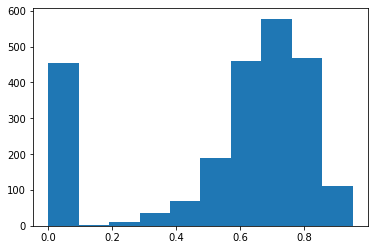

In [22]:
# iou values for all matching instances (no threshold)
plt.hist(hist['gt_overlap'])
plt.show()

### Visualization

In [75]:
predictor = DefaultPredictor(cfg)

In [76]:
dataset_dicts = get_dict("train")
bad_images_ind = [i['image_id'] for i in bad_images]
# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['image_id'] in bad_images_ind:
    dataset_dicts_anns.append(i)

In [77]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  from detectron2.utils.visualizer import Visualizer
  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  if predFlag:
    outputs = predictor(im)  
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  image = out.get_image()[:, :, ::-1]
  return image

In [78]:
from cv2 import hconcat
num_samples = 364
os.makedirs(model_name + "/predImagesTrain", exist_ok=True) # Make a directory for output images
#random.seed(1)
for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True) # Predictions
  image2 = printImage(d, test_metadata, False) # Ground truth
  image3 = hconcat([image1, image2])
  #cv2_imshow(image3)
  cv2.imwrite(model_name + '/predImagesTrain/' + str(d["image_id"] + '.jpg'), image3)